<a href="https://colab.research.google.com/github/theQuert/inlpfun/blob/master/Demo/Sentiment_Analysis_of_Covid19_Vaccination_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip3 install transformers
!pip3 install spacy cssselect
!python3 -m spacy download en_core_web_sm
import re
import numpy as np
import pandas as pd
import os, json
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import urllib
from urllib import request
import requests
import time 
import datetime
import random
from bs4 import BeautifulSoup
from transformers import pipeline, BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
en_stop = set(nltk.corpus.stopwords.words('english'))
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print(device)

cuda


#### Training

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/NCCU_BD21

/content/drive/MyDrive/Colab Notebooks/NCCU_BD21


In [16]:
df = pd.read_csv('tweet_dataset.csv')

In [17]:
df.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier a...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,We want to trade with someone who has Houston...,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


We only extract `text` and `new_sentiment`

In [18]:
train = pd.DataFrame()
train['text'] = df['text']
train['Sentiment'] = df['new_sentiment']

Drop NaN

In [19]:
train = train.dropna()
train.isnull().sum()

text         0
Sentiment    0
dtype: int64

In [20]:
train['Sentiment'] = train['Sentiment'].replace(['negative', 'neutral', 'positive'], [0, 1, 2])

In [21]:
train.head()

,text,Sentiment
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,2
4,We want to trade with someone who has Houston...,1
5,Re-pinging : why didn`t you go to prom? BC my ...,0


#### Import BERT Tokenizer

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

#### Preprocessing

In [23]:
for tweet in train['text']:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)

    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    max_len = max(0, len(input_ids))

print('Max sequence length: ', max_len)

Max sequence length:  33


In [ ]:
input_ids = []
attention_masks = []

for sent in train['text']:
    encoded_dict = tokenizer.encode_plus(
        sent,
        # padding=True, 
        truncation=True,
        max_length=110,
        pad_to_max_length=True,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train['Sentiment'].tolist())

#### Datasets and DataLoaders

In [25]:
# Create the dataset wrapping tensors 
# input_ids, attention_masks, labels
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [26]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size = batch_size
)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels = 3, 
    output_attentions = False,
    output_hidden_states = False
)

In [7]:
# model = torch.load('tuned_model.pt')

#### Optimizer and Scheduler

In [28]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps=1e-8)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [29]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### Training Loop

In [ ]:
epochs=5

model.to(device)

training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids = None,
                       attention_mask = b_attention_mask,
                       labels = b_labels,
                       return_dict=True)
        
        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print(" Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Training epcoh took: {:}".format(training_time))

In [ ]:
print("Running Validation...")
t0 = time.time()

model.eval()

total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [73]:
# Save tuned model
# torch.save(model,'tuned_model.pt')

#### Prediction

In [32]:
df_vax = pd.read_csv('vaccination_all_tweets.csv')
df_vax.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [33]:
#@title Time Inputs for observation
df_vax_weeks = df_vax.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_date = '2021-11-01 0:00:00' #@param {type: "string"}
end_date = '2021-11-20 23:59:59' #@param {type: "string"}
duration = (df_vax_weeks['date'] > start_date) & (df_vax_weeks['date'] <= end_date)
df_vax_weeks = df_vax_weeks.loc[duration]

In [24]:
# df_vax_weeks.head()
# df_vax_weeks.shape

In [25]:
# df_vax_weeks.head()

In [34]:
# extract texts
vax_tweets = df_vax_weeks['text']

#### Pre-processing tweets

In [ ]:
input_ids = []
attention_masks = []

for tweet in vax_tweets:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    tweet = re.sub(r'\S+\.com\S+','', tweet)
    tweet = re.sub(r'\@\w+','', tweet)
    tweet = re.sub("\ ","", tweet)
    tweet = re.sub("\'","", tweet)
    tweet = re.sub("\\n'","", tweet)
    tweet = re.sub('#\w+', '', tweet)

    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens = True,
        max_length = 110,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, 0)
attention_masks = torch.cat(attention_masks, 0)

#### Dataset and DataLoader

In [36]:
# batch_size = 32

vax_dataset = TensorDataset(input_ids, attention_masks)
vax_dataloader = DataLoader(
    vax_dataset,
    sampler = SequentialSampler(vax_tweets),
    batch_size = batch_size
)

#### Prediction

In [37]:
# model = torch.load('tuned_model.pt')
print(f'Predicting sentiments for {len(input_ids)} vaccine tweets')
model.eval()

predictions = []

for batch in vax_dataloader:
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  logits=np.argmax(logits,axis=1)
  
  for i in range(len(logits)):
      predictions.append(logits[i])
print('DONE')

Predicting sentiments for 12692 vaccine tweets
DONE


In [38]:
df_vax_weeks['Sentiment'] = predictions
df_vax_weeks = df_vax_weeks.dropna()
df_vax_weeks.isnull().sum()
# df_vax_weeks.head()

id                  0
user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
retweets            0
favorites           0
is_retweet          0
Sentiment           0
dtype: int64

In [31]:
# df_vax_weeks.info()

In [39]:
vax = df_vax_weeks.drop(['user_name', 'user_description', 'user_created', 'user_followers',
                   'user_friends', 'user_favourites', 'source', 'is_retweet'], axis=1)
# Concern saving the followers for more analysis

In [33]:
# vax.head()

In [40]:
vax['text'] = vax['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
vax['text'] = vax['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
vax['text'] = vax['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
vax['text'] = vax['text'].str.replace("\\n'", "", regex=True)

In [35]:
# vax['text'].head()

In [41]:
vax['Sentiment'] = vax['Sentiment'].replace([0, 1, 2], ['negative', 'neutral', 'positive'])
# vax['Sentiment'] = vax['Sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

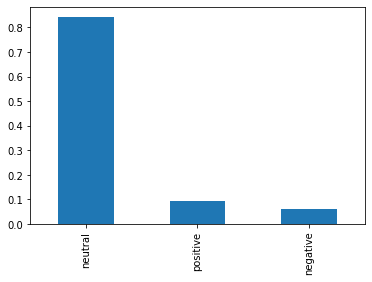

In [42]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [43]:
vax['date'] = pd.to_datetime(vax['date'], errors='coerce').dt.date
vax['Sentiment'] = vax['Sentiment'].replace(['negative', 'neutral', 'positive'],
                                            [-1, 0, 1])
# vax['Sentiment'] = vax['Sentiment'].map({'negative': -1, 'nrutral': 0, 'positive': 1})

In [39]:
# vax.head()

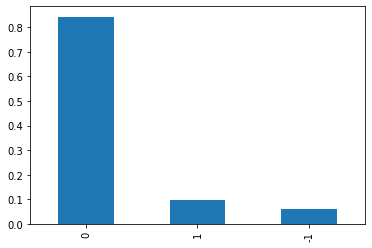

In [44]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [45]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik', 'johnson']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine'] = all_vax
sentiments = list()

#### Vaccine with Time

In [46]:
def time_variance(vacc) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    
    fg, axs = plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs, x='date', y='Sentiment', data=temp)
    axs.set_xlabel("Time", size=16)
    axs.set_ylabel("Sentiment", size=16)
    axs.set_title("Variance of Sentiment wrt Time", size=24)
    axs.grid()

#### Mean overall sentiment

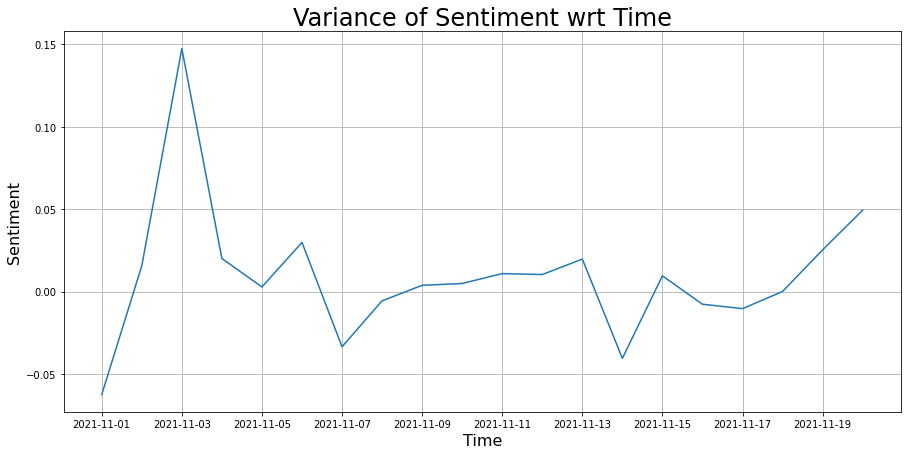

In [47]:
time_variance('all')

#### Moderna, Pfizer, JJ, COVAXIN, Sinopharm, Sinovac, AZ, Sputnik

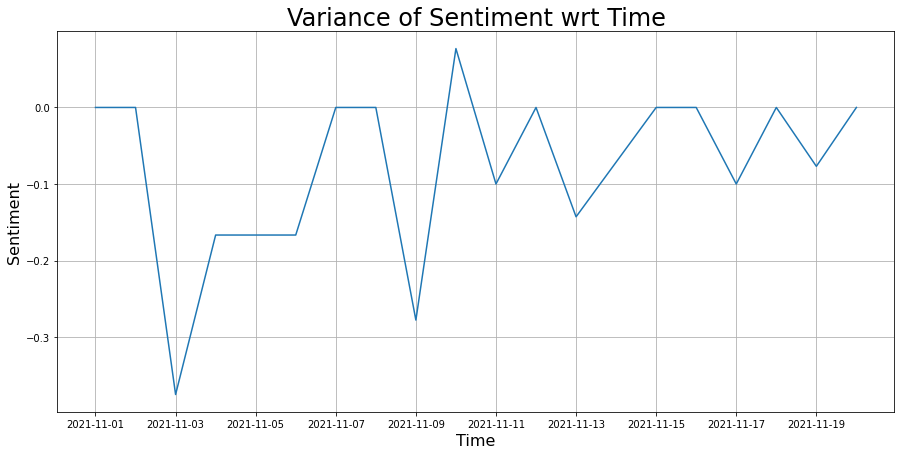

In [48]:
time_variance('moderna')

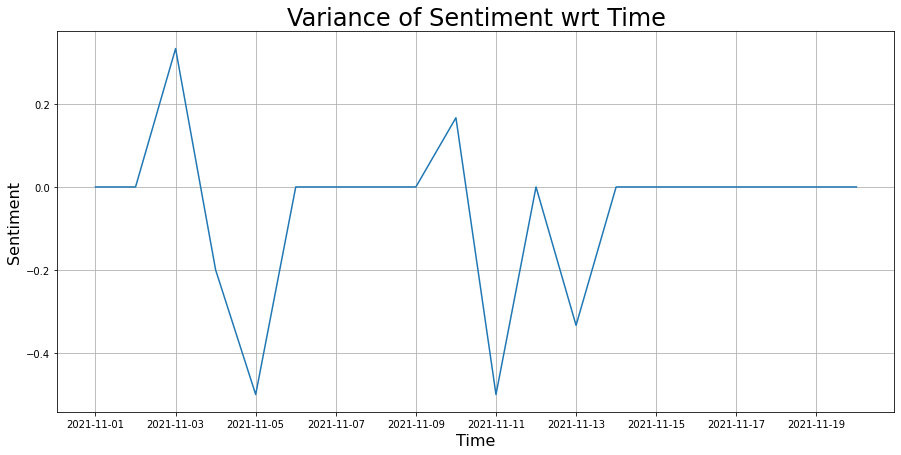

In [49]:
time_variance('pfizer')

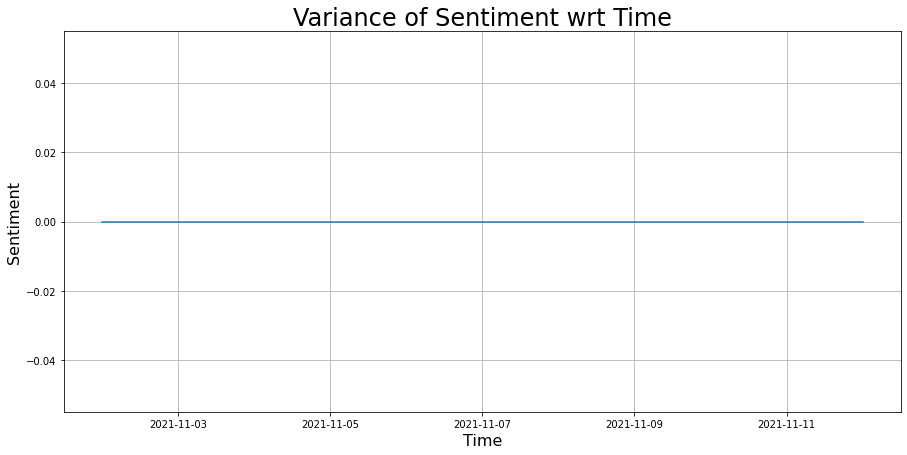

In [50]:
time_variance('johnson')

In [47]:
# time_variance('covaxin')
# time_variance('sinovac')
# time_variance('sinopharm')
# time_variance('biontech')
# time_variance('oxford')
# time_variance('astrazeneca')
# time_variance('sputnik')

### Comparison among Countries

In [51]:
def time_variance_country(country) :
    count = vax[vax['user_location'].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title(f"Variance of Sentiment wrt Time",size=24)
    axs.grid()

In [49]:
# time_variance_country('india')

In [50]:
# time_variance_country('canada')

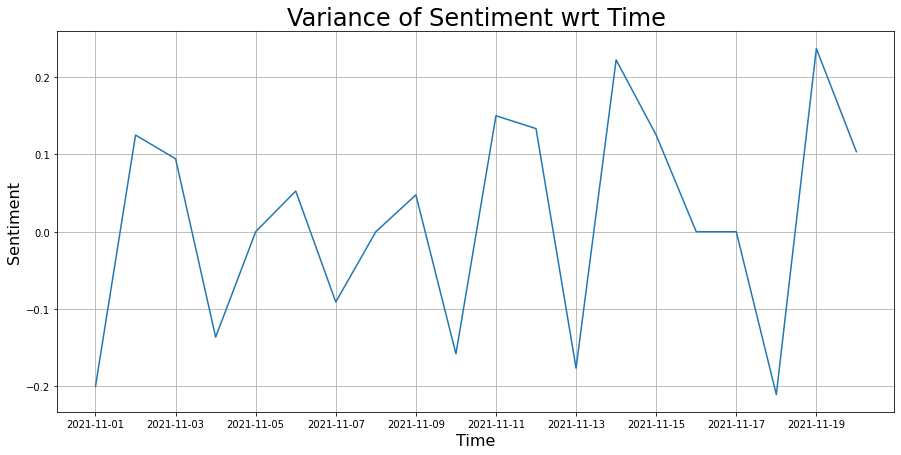

In [52]:
time_variance_country('usa')

The variance of sentiments in different countries seems to be more erratic. The varition might be the politics and economic matters among them.

# WordCloud

In [53]:
df_vax_tweets = vax_tweets.to_frame()
text_for_wd = str(df_vax_tweets['text'].values)

In [54]:
text_for_wd_pro = re.sub(r"http\S+", "", text_for_wd)
text_for_wd_pro = re.sub(r'\S+\.com\S+','', text_for_wd_pro)
text_for_wd_pro = re.sub(r'\@\w+','', text_for_wd_pro)
text_for_wd_pro = re.sub("\ ","", text_for_wd_pro)
text_for_wd_pro = re.sub("\'","", text_for_wd_pro)
text_for_wd_pro = re.sub("\\n'","", text_for_wd_pro)

(-0.5, 999.5, 499.5, -0.5)

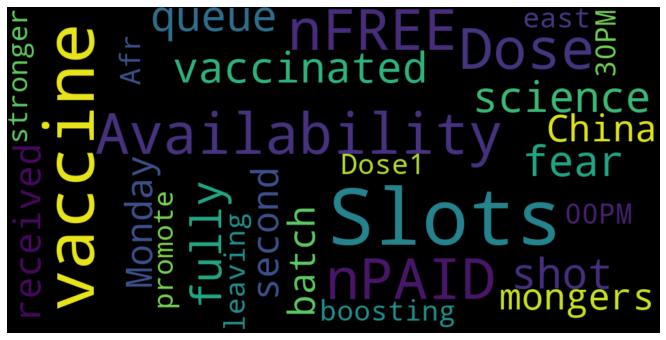

In [55]:
# without hashtags
words = str(vax['text'].values)
word_cloud = WordCloud(width=1000, height=500, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

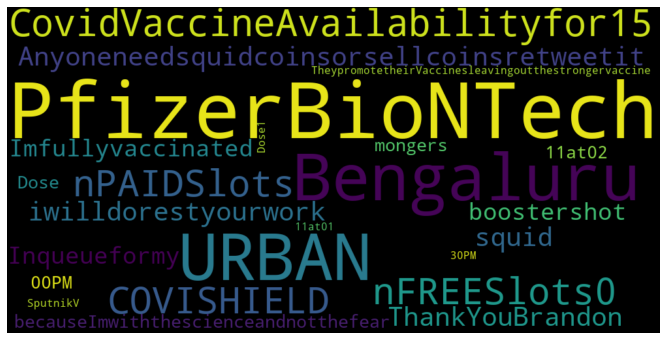

In [56]:
# with hashtags
words = text_for_wd_pro
word_cloud = WordCloud(width=1000, height=500, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

# Topic Modeling

In [ ]:
!pip3 install sentence-transformers
!pip3 install pyLDAvis
!pip3 install bertopic bertopic[visualization]
import pyLDAvis
import pyLDAvis.gensim_models

In [57]:
# df_vax_tweets.head()

In [ ]:
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace("\\n'", "", regex=True)

In [59]:
# df_vax_tweets.head()

In [59]:
df_vax_wks = df_vax_weeks.copy()

In [61]:
# df_vax_wks.head()

In [ ]:
# df_vax_wks['text'] = df_vax_wks['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('#', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace("\\n'", "", regex=True)

In [63]:
# df_vax_wks.head()

In [61]:
df_vax_wks = df_vax_weeks.drop(['user_name', 'user_description', 'user_created', 'user_followers',
                   'user_friends', 'user_favourites', 'source', 'is_retweet', 'id', 'user_location', 'user_verified', 'hashtags', 'retweets', 'favorites'], axis=1)

In [62]:
df_vax_wks['text'] = df_vax_wks['text'].str.replace('#', '', regex=True)

In [66]:
# df_vax_wks.head()

In [ ]:
df_vax_pre = df_vax_wks.copy()
nlp = spacy.load('en_core_web_sm')

In [64]:
# Preprocessing texts
def make_lower_case(text):
    return text.lower()

def make_tokenize(text):
    return [w for w in text.split()]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
    
def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    text = [w for w in text if not w in stop_words]
    texts = [w for w in text if w.isalpha()]
    texts = " ".join(texts)
    return texts

df_vax_pre['text'] = df_vax_pre['text'].apply(make_lower_case)
df_vax_pre['text'] = df_vax_pre['text'].apply(make_tokenize)
df_vax_pre['text'] = df_vax_pre['text'].apply(lemmatize)
df_vax_pre['text'] = df_vax_pre['text'].apply(remove_stop_words)

In [69]:
# df_vax_pre.head()

In [65]:
# create embeddings with pre-trained model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

sentences = []
for id in range(df_vax_pre.shape[0]):
    sentences.append(df_vax_pre.iloc[id, :]['text'])

embeddings = model.encode(sentences, show_progress_bar=True)

Batches:   0%|          | 0/236 [00:00<?, ?it/s]

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=35, verbose=True)
topics, _ = topic_model.fit_transform(sentences)

In [67]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2154,-1_covaxin_covid_vaccine_moderna
1,0,386,0_sinovac_sinopharm_dos_china
2,1,232,1_vaccine_covaxin_traditional_approved
3,2,222,2_urban_paid_slot_bengaluru
4,3,202,3_vaccine_vaccinated_moderna_safe
5,4,189,4_approval_approve_covaxin_approved
6,5,175,5_moderna_thanks_love_like
7,6,173,6_adult_fda_pfizer_booster
8,7,165,7_booster_got_moderna_getting
9,8,164,8_pfizer_pfizergate_pfizerbiontech_johnsonandj...


In [68]:
topic_nr = freq.iloc[3]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown below

[('urban', 0.14758860408115268),
 ('paid', 0.1194344640401468),
 ('slot', 0.11888230065447453),
 ('bengaluru', 0.08265545459026848),
 ('availability', 0.08229644436091078),
 ('free', 0.08135482286515322),
 ('covishield', 0.08060615819917812),
 ('covidvaccine', 0.074704596052519),
 ('', 1e-05),
 ('', 1e-05)]

In [70]:
%%capture
fig = topic_model.visualize_topics()

In [71]:
fig

In [72]:
# output topic graph
fig.write_html("topic_fig.html")

In [73]:
scores_map = topic_model.visualize_barchart(); scores_map

In [74]:
# output scores map of keywords
scores_map.write_html('scores_fig.html')

In [75]:
timestamps = df_vax_wks['date'].to_list()

topics_over_time = topic_model.topics_over_time(docs=sentences, 
                                                topics=topics, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

20it [00:01, 18.36it/s]


In [76]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [77]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20).write_html('topic_over_time.html')

In [78]:
topic_model.get_representative_docs()

{0: ['chinese drugmaker sinovac supply vaccine dos pharmaceutical company',
  'take clear air india v china claim',
  'chinese vaccine ystd million sinovac vaccine arrived'],
 1: ['wait till see doe covaxin change vaccine',
  'covid going problem vaccine covaxin best shelf life',
  'vaccine covaxin'],
 2: ['urban bengaluru covidvaccine availability free slot paid slot covishield',
  'urban bengaluru covidvaccine availability free slot paid slot covishield',
  'urban bengaluru covidvaccine availability free slot paid slot covishield'],
 3: ['vaccinated firstdose moderna',
  'first dose vaccine moderna san juan city',
  'boosted bitch moderna vaccinated'],
 4: ['version correct delay approval covaxin intentional negative',
  'waiting approve covaxin',
  'covaxin approval ha long call due data politics come time'],
 5: ['sound like moderna trying cake eat someone else paid cake',
  'moderna justsaying',
  'moderna need learn'],
 6: ['firstdonoharm holdtheline pfzier moderna fda booster',


In [ ]:
#@title Use keywords to find topic
keywords_inputs = 'word_1 word_2' #@param {type: "string"}
topic_model.find_topics(keywords_inputs)

In [79]:
topic_model.visualize_heatmap()

/usr/local/lib/python3.7/dist-packages/plotly/express/_imshow.py:349: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
topic_model.save('topic_model')

# Trend Analysis

### Daily vaccinations

In [124]:
datadf_vax_daily = pd.read_csv('country_vaccinations.csv')

In [ ]:
# datadf_vax.head()

In [125]:
col_names_daily = ['country', 'people_fully_vaccinated' ,'date', 'daily_vaccinations', 'vaccines']
datadf_vax_col_daily = datadf_vax_daily[col_names_daily]

In [126]:
data_df_usa_daily = datadf_vax_col_daily.loc[datadf_vax_daily['country']=='United States']

In [ ]:
# data_df_usa.head()

In [127]:
#@title Time inputs
df_vax_weeks_usa_daily = data_df_usa_daily.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_date = '2021-10-31 23:59:59' #@param {type: "string"}
end_date = '2021-11-20 23:59:59' #@param {type: "string"}
duration = (df_vax_weeks_usa_daily['date'] > start_date) & (df_vax_weeks_usa_daily['date'] <= end_date)

df_vax_weeks_usa_daily = df_vax_weeks_usa_daily.loc[duration]

In [129]:
df_vax_weeks_usa_daily.head()

,country,people_fully_vaccinated,date,daily_vaccinations,vaccines
57758,United States,191747651.0,2021-11-01,1251747.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57759,United States,191926649.0,2021-11-02,1242202.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57760,United States,192108697.0,2021-11-03,1231872.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57761,United States,192290907.0,2021-11-04,1232589.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57762,United States,192508427.0,2021-11-05,1244801.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


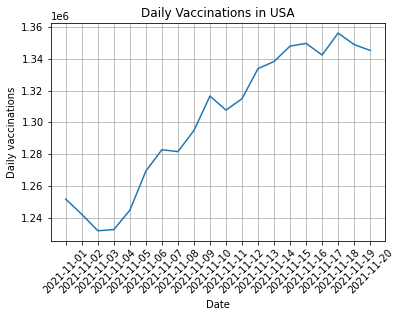

In [128]:
import matplotlib.pyplot as plt
axis_1 = df_vax_weeks_usa_daily['date']
axis_2 = df_vax_weeks_usa_daily['daily_vaccinations']
ano = df_vax_weeks_usa_daily['people_fully_vaccinated']
plt.title("Daily Vaccinations in USA")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_1, axis_2)
plt.grid(True)
plt.show()
# plt.plot(axis_1, ano, '--')

### Daily vaccinations for each brand

In [86]:
# Johnson&Johnson, Moderna, Pfizer/BioNTech
df_brand = pd.read_csv('country_vaccinations_by_manufacturer.csv')

In [ ]:
# df_brand.head()

In [87]:
df_brand = df_brand.loc[df_brand['location']=='United States']

In [88]:
#@title Time Inputs
df_brand_weeks = df_brand.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_time = '2021-10-31 23:59:59' #@param {type:"string"}
end_time = '2021-11-20 23:59:59' #@param {type:"string"}
duration = (df_brand_weeks['date'] > start_date) & (df_brand_weeks['date'] <= end_date)
df_brand_weeks = df_brand_weeks.loc[duration]

In [ ]:
# df_brand_weeks.head()

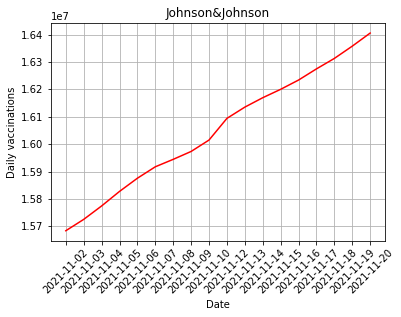

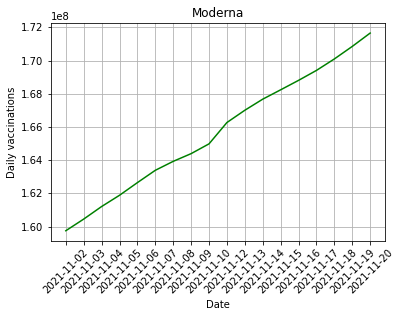

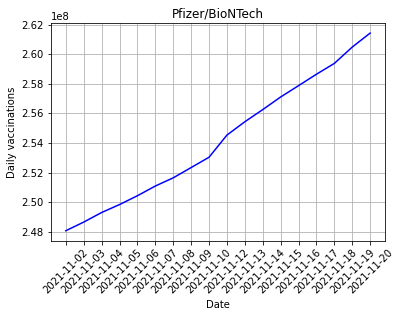

In [90]:
# Johnson&Johnson, Moderna, Pfizer/BioNTech
sel_jj = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Johnson&Johnson']
sel_moderna = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Moderna']
sel_pfizer = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Pfizer/BioNTech']

axis_0 = sel_jj['date']
axis_1 = sel_jj['total_vaccinations']
axis_2 = sel_moderna['total_vaccinations']
axis_3 = sel_pfizer['total_vaccinations']

plt.title("Johnson&Johnson")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_1, 'r', label='Johnson&Johnson')
plt.grid(True)
plt.show()

plt.title("Moderna")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_2, 'g', label='Moderna')
plt.grid(True)
plt.show()

plt.title("Pfizer/BioNTech")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_3, 'b', label='Pfizer/BioNTech')
plt.grid(True)
plt.show()

# plt.plot(axis_1, ano, '--')

In [91]:
variance_jj = []
variance_moderna = []
variance_pfizer = []
variance_jj.append(0)
variance_moderna.append(0)
variance_pfizer.append(0)
for id in range(1, sel_jj.shape[0]):
    variance_jj.append(((sel_jj.iloc[id, 3]-sel_jj.iloc[id-1, 3])/sel_jj.iloc[id-1, 3])*100)
for id in range(1, sel_moderna.shape[0]):
    variance_moderna.append(((sel_moderna.iloc[id, 3]-sel_moderna.iloc[id-1, 3])/sel_moderna.iloc[id-1, 3])*100)
for id in range(1, sel_pfizer.shape[0]):
    variance_pfizer.append(((sel_pfizer.iloc[id, 3]-sel_pfizer.iloc[id-1, 3])/sel_pfizer.iloc[id-1, 3])*100)

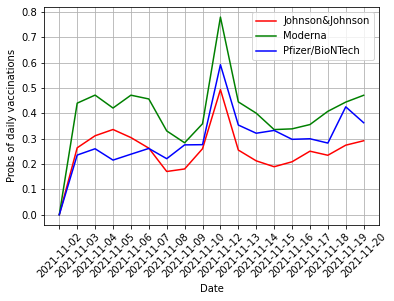

In [92]:
axis_0 = sel_jj['date']
fig, ax = plt.subplots()
plt.xticks(rotation=45)
plt.plot(axis_0, variance_jj, 'r', label='Johnson&Johnson')
plt.plot(axis_0, variance_moderna, 'g', label='Moderna')
plt.plot(axis_0, variance_pfizer, 'b', label='Pfizer/BioNTech')
plt.legend(['Johnson&Johnson', 'Moderna', 'Pfizer/BioNTech'])
plt.ylabel("Probs of daily vaccinations")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### Pie chart for brands

In [93]:
row = sel_jj.shape[0]-1
sel_jj_total = sel_jj.iloc[row, 3]
sel_moderna_total = sel_moderna.iloc[row, 3]
sel_pfizer_total = sel_pfizer.iloc[row, 3]

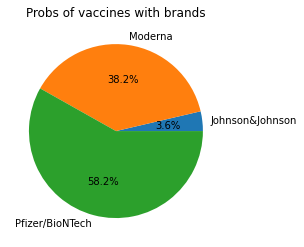

In [94]:
labels = ['Johnson&Johnson', 'Moderna', 'Pfizer/BioNTech']
size = [sel_jj_total, sel_moderna_total, sel_pfizer_total]
plt.pie(size , labels = labels,autopct='%1.1f%%')
plt.title('Probs of vaccines with brands')
plt.show()

# Duration of interest

### Variance of sentiments

In [95]:
def sents_var_plot(vacc) :
    if vacc == 'all':
        vacc = vax
    else:   
        vacc = vax[vax['text'].str.lower().str.contains(vacc)] # vax: store the tweets contain vacc in list
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti = list()
    var = list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    var.append(0)
    
    for idx in range(1, len(senti)):
        var.append(senti[idx]-senti[idx-1])
 
    axis_0 = temp['date']
    fig, ax = plt.subplots()
    plt.xticks(rotation=45)
    plt.plot(axis_0, var, 'r', label=vacc)

    plt.ylabel("Sentiment Probs of daily vaccinations")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

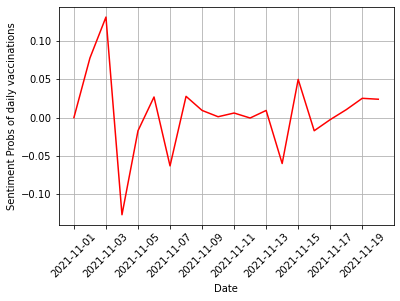

In [96]:
sents_var_plot('all')

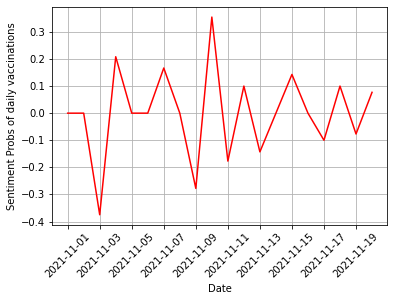

In [97]:
sents_var_plot('moderna')

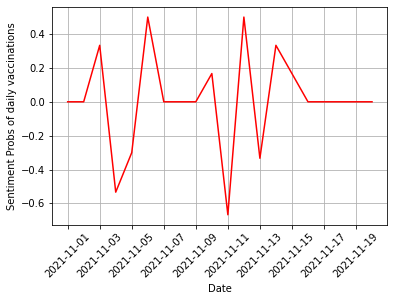

In [98]:
sents_var_plot('pfizer')

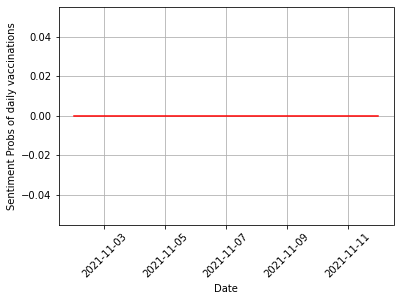

In [99]:
sents_var_plot('johnson')

In [100]:
# automatic reporting mechanism: sentiment
def sents_var_rep(vacc):
    if vacc == 'all':
        vacc = vax
    else :   
        vacc = vax[vax['text'].str.lower().str.contains(vacc)] # vax: store the tweets contain vacc in list
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti = list()
    var = list()
    date_alert = list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())
    temp['Sentiment'] = senti
    var.append(0)

    for idx in range(1, len(senti)):
        var.append(senti[idx]-senti[idx-1])

    var_abs =  [abs(ele) for ele in var]
    var_abs_mean = np.mean(var_abs, axis=0)
    for idx in range(len(var_abs)):
        if var_abs[idx] > var_abs_mean:
            date_alert.append(temp['date'].iloc[idx])
    return date_alert

In [101]:
var_rep_all = sents_var_rep('all')
var_rep_moderna = sents_var_rep('moderna')
var_rep_pfizer = sents_var_rep('pfizer')
var_rep_jj = sents_var_rep('johnson')

In [ ]:
# set(var_rep_all).intersection(var_rep_moderna)
# set(var_rep_all).intersection(var_rep_pfizer)

In [102]:
set(var_rep_moderna).intersection(var_rep_pfizer)

{datetime.date(2021, 11, 3),
 datetime.date(2021, 11, 4),
 datetime.date(2021, 11, 11),
 datetime.date(2021, 11, 13)}

### Variance of vaccinations
##### automatic reporting system

In [103]:
variance_jj_mean = np.mean(variance_jj, axis=0)
variance_moderna_mean = np.mean(variance_moderna, axis=0)
variance_pfizer_mean = np.mean(variance_pfizer, axis=0)

vax_var_rep_jj = list()
vax_var_rep_moderna = list()
vax_var_rep_pfizer = list()
for idx in range(len(variance_jj)):
    if variance_jj[idx] > variance_jj_mean:
        vax_var_rep_jj.append(sel_jj['date'].iloc[idx])
for idx in range(len(variance_moderna)):
    if variance_moderna[idx] > variance_moderna_mean:
        vax_var_rep_moderna.append(sel_moderna['date'].iloc[idx])
for idx in range(len(variance_jj)):
    if variance_pfizer[idx] > variance_pfizer_mean:
        vax_var_rep_pfizer.append(sel_pfizer['date'].iloc[idx])

In [104]:
set(vax_var_rep_pfizer).intersection(vax_var_rep_moderna)

{'2021-11-12', '2021-11-13', '2021-11-19', '2021-11-20'}

# Multi-Documents Summarization

In [105]:
import re
import urllib
from urllib import request
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
import requests.packages.urllib3
requests.packages.urllib3.disable_warnings()

In [112]:
#@title Keywords input
keywords = 'pfizer children' #@param {type: "string"}
keywords = re.sub(' ', '+', keywords)
start_date = '2021-11-03' #@param {type: "string"}
end_date = '2021-11-05' #@param {type: "string"}
search_inputs = f'{keywords}+after%3A{start_date}+before%3A{end_date}'
url = f"https://www.google.com/search?q={search_inputs}&tbm=nws&lr=lang_en&hl=en&sort=date&num=19"
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
}

In [113]:
resp = requests.get(url, headers=headers)
soup = BeautifulSoup(resp.content, "html.parser")
soup_prettify = soup.prettify()
with open('url.html', 'w') as fwrite:
    fwrite.write(soup_prettify)

In [114]:
url_list = []
metas = []
for link in soup.find_all('a'):
    url_list.append(link.get('href'))
for url in url_list:
    if bool(re.findall('google.com', str(url)))==True:
        url_list.remove(url)
regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
for url in url_list:
    if bool(re.findall(regex, str(url)))==True:
        metas.append(url)
for meta in metas:
    if bool(re.findall('policies.google.com', str(meta)))==True:
        metas.remove(meta)

In [115]:
metas

['https://www.doh.wa.gov/Newsroom/Articles/ID/2957/Children-ages-5-11-now-eligible-for-Pfizer-BioNTech-COVID-19-vaccine',
 'https://www.jdnews.com/story/news/2021/11/04/pfizer-covid-vaccine-available-kids-onslow-county/6264687001/',
 'https://www.timesherald.com/2021/11/04/montgomery-county-scheduling-pfizer-covid-19-vaccinations-for-children-ages-5-11',
 'https://shawneemissionpost.com/2021/11/04/johnson-county-chidlren-vaccine-135979/',
 'https://www.kshb.com/news/coronavirus/kansas-city-area-locations-offering-the-pfizer-vaccine-for-children-ages-5-11',
 'https://www.auburn-reporter.com/northwest/children-ages-5-to-11-eligible-for-pfizer-biontech-covid-19-vaccine/',
 'https://www.mecknc.gov/news/Pages/Pfizer%20COVID-19%20Pediatric%20Vaccine%20for%20Children%20Ages%205-11%20Now%20Available.aspx',
 'https://www.news4jax.com/news/local/2021/11/04/heres-where-children-ages-5-11-can-get-pfizer-covid-19-vaccine/',
 'https://www.npr.org/2021/11/04/1052366451/parents-covid-vaccine-kids-5-11

In [117]:
inputs = []
for meta in metas:
    resp = requests.get(meta, headers=headers, verify=False)
    soup = BeautifulSoup(resp.content, "html.parser")
    title = soup.title.string
    title_filtered = re.sub(r'(\s)-(\s)(\w+).+', '', title)
    title_filtered = title_filtered.strip('\r\n\t')
    inputs.append(title_filtered)

In [118]:
summarizer = pipeline("summarization")
summ=' '.join([str(i) for i in inputs])
summarized = summarizer(summ, min_length=5, max_length=20)
print(summarized)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


[{'summary_text': ' Children ages 5 – 11 now eligible for Pfizer-BioNTech COVID-'}]
